In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import seaborn as sns
import pandas as pd
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [8]:
ds_path = "/content/drive/MyDrive/FruitClassification/Fruitclassification/Train"

In [9]:
# Initialize a variable to store the total number of images
total_images = 0
for root, dirs, files in os.walk(ds_path):
  # Count the number of files in each directory
  num_files = len(files)
  total_images += num_files
print("Total number of images:", total_images)

# Count images per class
classes = os.listdir(ds_path)
images_per_class = {}
for class_name in classes:
  class_path = os.path.join(ds_path, class_name)
  if os.path.isdir(class_path):
    images_per_class[class_name] = len(os.listdir(class_path))
print("Total number of images per classes:", images_per_class)


Total number of images: 5076
Total number of images per classes: {'Mango': 737, 'Banana': 1169, 'Peach': 990, 'Grape': 1190, 'Cherry': 990}


In [10]:
import shutil
import random

# Base directories
base_dir = "/content/drive/MyDrive/FruitClassification/Fruitclassification"
train_dir = os.path.join(base_dir, "Train")
test_dir = os.path.join(base_dir, "Test")

# Ensure test directory exists
os.makedirs(test_dir, exist_ok=True)

# Loop over each class folder in Train
for class_name in os.listdir(train_dir):
    class_train_path = os.path.join(train_dir, class_name)
    class_test_path = os.path.join(test_dir, class_name)

    # Skip if it's not a folder
    if not os.path.isdir(class_train_path):
        continue

    # Create class folder in Test if not exists
    os.makedirs(class_test_path, exist_ok=True)

    # List image files in the class folder
    image_files = [f for f in os.listdir(class_train_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Shuffle and select 10% to move
    num_to_move = max(1, int(len(image_files) * 0.10))  # ensure at least one
    images_to_move = random.sample(image_files, num_to_move)

    # Move selected images to test folder
    for file_name in images_to_move:
        src = os.path.join(class_train_path, file_name)
        dst = os.path.join(class_test_path, file_name)
        shutil.move(src, dst)

    print(f"Moved {num_to_move} images from '{class_name}' to test set.")


Moved 73 images from 'Mango' to test set.
Moved 116 images from 'Banana' to test set.
Moved 99 images from 'Peach' to test set.
Moved 119 images from 'Grape' to test set.
Moved 99 images from 'Cherry' to test set.


In [11]:
import os
class_names = sorted(os.listdir(ds_path))
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 5 classes: ['Banana', 'Cherry', 'Grape', 'Mango', 'Peach']


In [12]:
from PIL import Image, UnidentifiedImageError
import os

corrupted_images = []

for class_name in class_names:
    class_path = os.path.join(ds_path, class_name)
    print(f"Checking in: {class_path}")

    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()
            except (IOError, UnidentifiedImageError):
                corrupted_images.append(img_path)
                print(f"Corrupted image detected: {img_path}")
                try:
                    os.remove(img_path)
                    print(f"Deleted: {img_path}")
                except Exception as e:
                    print(f"Failed to delete {img_path}: {e}")

# Summary
if corrupted_images:
    print(f"\nTotal corrupted images deleted: {len(corrupted_images)}")
else:
    print("\nNo corrupted images found.")


Checking in: /content/drive/MyDrive/FruitClassification/Fruitclassification/Train/Banana
Checking in: /content/drive/MyDrive/FruitClassification/Fruitclassification/Train/Cherry
Checking in: /content/drive/MyDrive/FruitClassification/Fruitclassification/Train/Grape
Checking in: /content/drive/MyDrive/FruitClassification/Fruitclassification/Train/Mango
Checking in: /content/drive/MyDrive/FruitClassification/Fruitclassification/Train/Peach

No corrupted images found.


In [13]:
from collections import Counter
from PIL import Image

def image_shapes_summary(directory):
    shapes = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        for image_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, image_name)
            try:
                with Image.open(img_path) as img:
                    shapes.append(img.size)
            except:
                pass
    shape_counts = Counter(shapes)
    print("Image sizes and their frequencies:")
    for shape, count in shape_counts.items():
        print(f"{shape}: {count} images")

image_shapes_summary(ds_path)

Image sizes and their frequencies:
(100, 100): 4570 images


In [14]:
test_ds = "/content/drive/MyDrive/FruitClassification/Fruitclassification/Test"

# Initialize a variable to store the total number of images
total_images = 0
for root, dirs, files in os.walk(test_ds):
  # Count the number of files in each directory
  num_files = len(files)
  total_images += num_files
print("Total number of images:", total_images)

# Count images per class
classes = os.listdir(test_ds)
images_per_class = {}
for class_name in classes:
  class_path = os.path.join(test_ds, class_name)
  if os.path.isdir(class_path):
    images_per_class[class_name] = len(os.listdir(class_path))
print("Total number of images per classes:", images_per_class)



Total number of images: 1695
Total number of images per classes: {'Mango': 244, 'Banana': 387, 'Peach': 331, 'Grape': 397, 'Cherry': 331}


In [15]:
train_ds = "/content/drive/MyDrive/FruitClassification/Fruitclassification/Train"

# Initialize a variable to store the total number of images
total_images = 0
for root, dirs, files in os.walk(train_ds):
  # Count the number of files in each directory
  num_files = len(files)
  total_images += num_files
print("Total number of images:", total_images)

# Count images per class
classes = os.listdir(train_ds)
images_per_class = {}
for class_name in classes:
  class_path = os.path.join(train_ds, class_name)
  if os.path.isdir(class_path):
    images_per_class[class_name] = len(os.listdir(class_path))
print("Total number of images per classes:", images_per_class)



Total number of images: 4570
Total number of images per classes: {'Mango': 664, 'Banana': 1053, 'Peach': 891, 'Grape': 1071, 'Cherry': 891}


In [16]:

# Define the path to the directory containing the images
train_ds = tf.keras.utils.image_dataset_from_directory(
ds_path,
batch_size=32,
image_size=(100, 100),
shuffle=True,
seed=123,
validation_split=0.2,
subset="training",
)


Found 4570 files belonging to 5 classes.
Using 3656 files for training.


In [17]:
val_ds = tf.keras.utils.image_dataset_from_directory(
ds_path,
batch_size=32,
image_size=(100, 100),
shuffle=True,
seed=123,
validation_split=0.2,
subset="validation",
)


Found 4570 files belonging to 5 classes.
Using 914 files for validation.


In [18]:
# Augmentation and normalization
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])


train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=5)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=5)))

In [19]:
import os
class_names = sorted(os.listdir(ds_path))
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 5 classes: ['Banana', 'Cherry', 'Grape', 'Mango', 'Peach']


Text(0.5, 1.0, 'Grape')

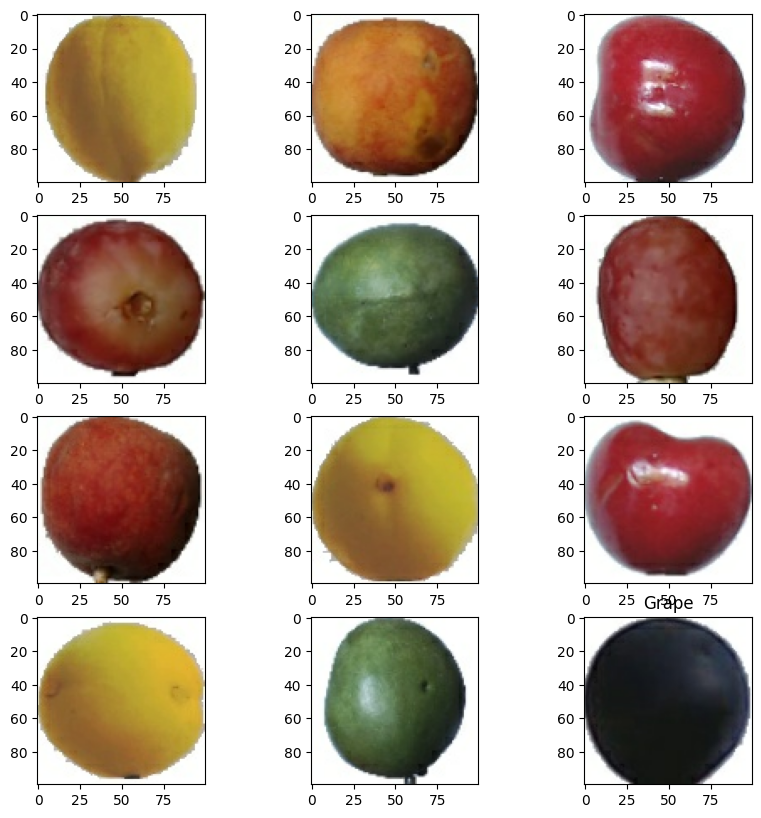

In [20]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_index = tf.argmax(labels[i].numpy())
plt.title(class_names[class_index])

<ipython-input-21-8e5a6810bb72>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data["Class"], y=data["Number of Images"], palette="Set2")


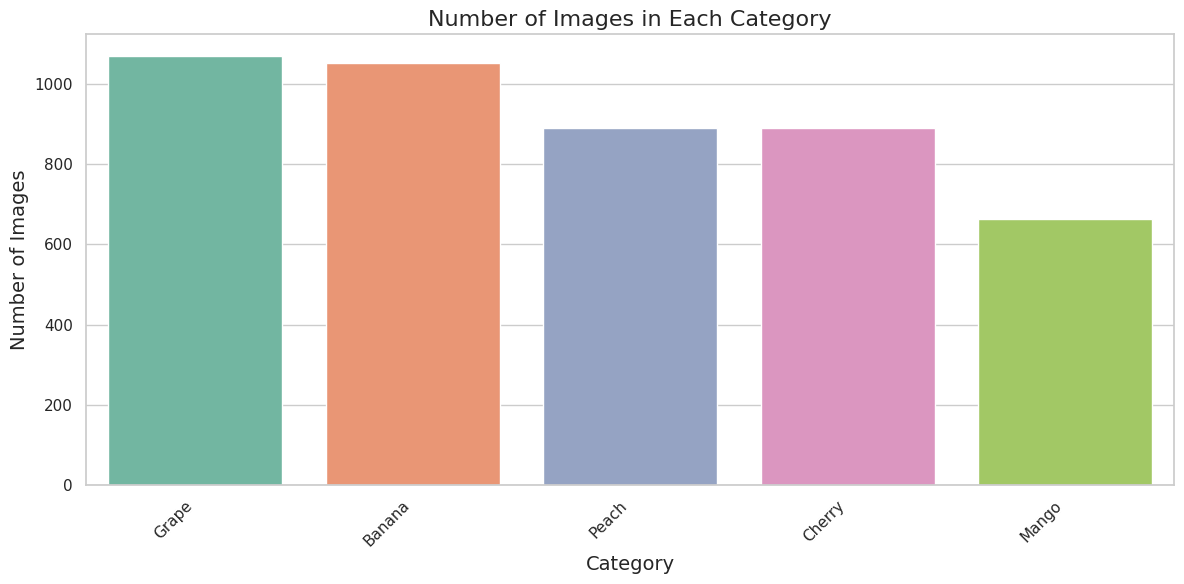

In [21]:

import matplotlib.pyplot as plt
import seaborn as sns

def plot_image_category_distribution(directory):
    categories = []

    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            num_images = len([image_name for image_name in os.listdir(class_dir) if image_name.lower().endswith('.jpg')])
            categories.append((class_name, num_images))

    categories.sort(key=lambda x: x[1], reverse=True)

    class_names, image_counts = zip(*categories)

    data = {"Class": class_names, "Number of Images": image_counts}

    sns.set(style="whitegrid", palette="muted")

    plt.figure(figsize=(12, 6))
    sns.barplot(x=data["Class"], y=data["Number of Images"], palette="Set2")

    plt.xticks(rotation=45, ha="right")

    plt.title("Number of Images in Each Category", fontsize=16)
    plt.xlabel("Category", fontsize=14)
    plt.ylabel("Number of Images", fontsize=14)

    plt.tight_layout()
    plt.show()

plot_image_category_distribution(ds_path)


In [22]:
def generate_model(image_height, image_width, nchannels, num_classes):
  """
  This function will generate a model with set of hyperparameters defined above.
  Input Args:
  image_height[int] = Height of an image.
  image_width[int] = Width of an image.
  nchannels[int] = Number of channels in image.
  num_classes[int] = Number of classes in dataset.
  Output Args:
  model-> A CNN model.
  """
  baseline_model = tf.keras.Sequential([
      # Rescaling and input layer, [For keras the input shape must be(image height, image width, channels)]
      layers.Rescaling(1./255, input_shape=(image_height,image_width, nchannels)),
      # First Block of Convolution and Pooling Operations.
      layers.Conv2D(32, (3,3), padding="same", activation="relu"),
      layers.MaxPooling2D(2,2),
      # Second Block of Convolution and Pooling Operations.
      layers.Conv2D(64, (3,3), padding="same", activation="relu"),
      layers.MaxPooling2D(2,2),
      # Third Block of Convolution and Pooling Operations.
      layers.Conv2D(128, (3,3), padding="same", activation="relu"),
      layers.MaxPooling2D(2,2),

      # Fully connected classifier.
      layers.Flatten(),
      layers.Dense(128, activation="relu"),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(num_classes, activation='softmax')
  ])
  return baseline_model

In [23]:
batch_size = 32
img_height = 100
img_width = 100
dropout_rate = 0.2

In [24]:
num_classes = len(class_names)
baseline_model = generate_model(img_height, img_width, 3, num_classes)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
baseline_model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])


In [26]:
baseline_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,463,173 (9.40 MB)

 Trainable params: 2,463,173 (9.40 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
callbacks = [
keras.callbacks.ModelCheckpoint(filepath="model_at_epoch_{epoch}.keras"),
keras.callbacks.EarlyStopping(monitor="val_loss", patience=5 ),
]

In [28]:
epochs = 40
history = baseline_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callbacks]
)

Epoch 1/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.7095 - loss: 0.6780 - val_accuracy: 0.9978 - val_loss: 0.0417
Epoch 2/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step - accuracy: 0.9982 - loss: 0.0106 - val_accuracy: 1.0000 - val_loss: 8.9431e-05
Epoch 3/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - accuracy: 1.0000 - loss: 4.2977e-05 - val_accuracy: 1.0000 - val_loss: 7.8774e-05
Epoch 4/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 1.0000 - loss: 2.6188e-05 - val_accuracy: 1.0000 - val_loss: 6.1979e-05
Epoch 5/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 1.0000 - loss: 1.8068e-05 - val_accuracy: 1.0000 - val_loss: 4.6626e-05
Epoch 6/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 1.0000 - loss: 1.3211e-05 - val_accuracy: 1.0000 - val_loss: 3.5235e-05
Epoch 7/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 1.0000 - loss: 1.0291e-05 - val_accuracy: 1.0000 - val_loss: 2.8205e-05
Epoch 8/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s

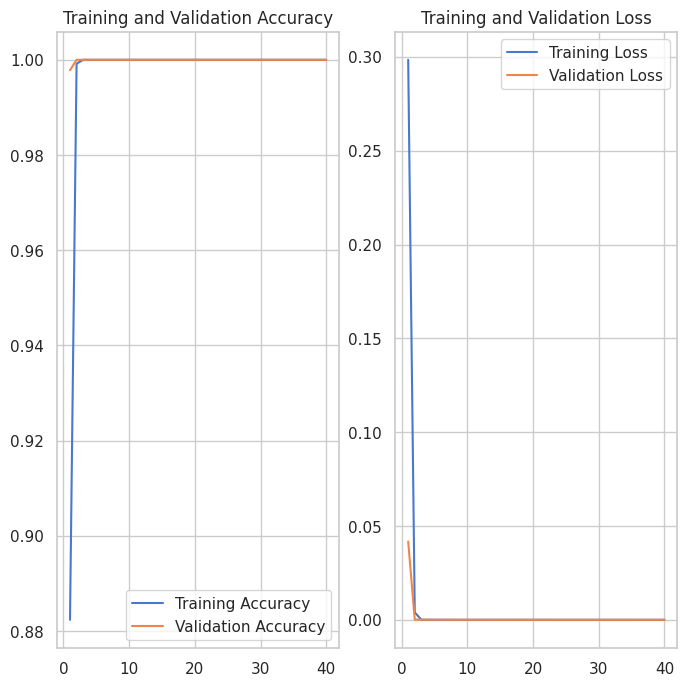

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Adjust the lengths of the arrays to match the actual number of epochs executed
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
test_loss, test_accuracy = baseline_model.evaluate(val_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 4.9290e-07
Test Loss: 6.29145461061853e-07
Test Accuracy: 1.0


Found 1690 files belonging to 5 classes.
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 1.0000 - loss: 9.6705e-07
Test Loss: 4.165632390140672e-07
Test Accuracy: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


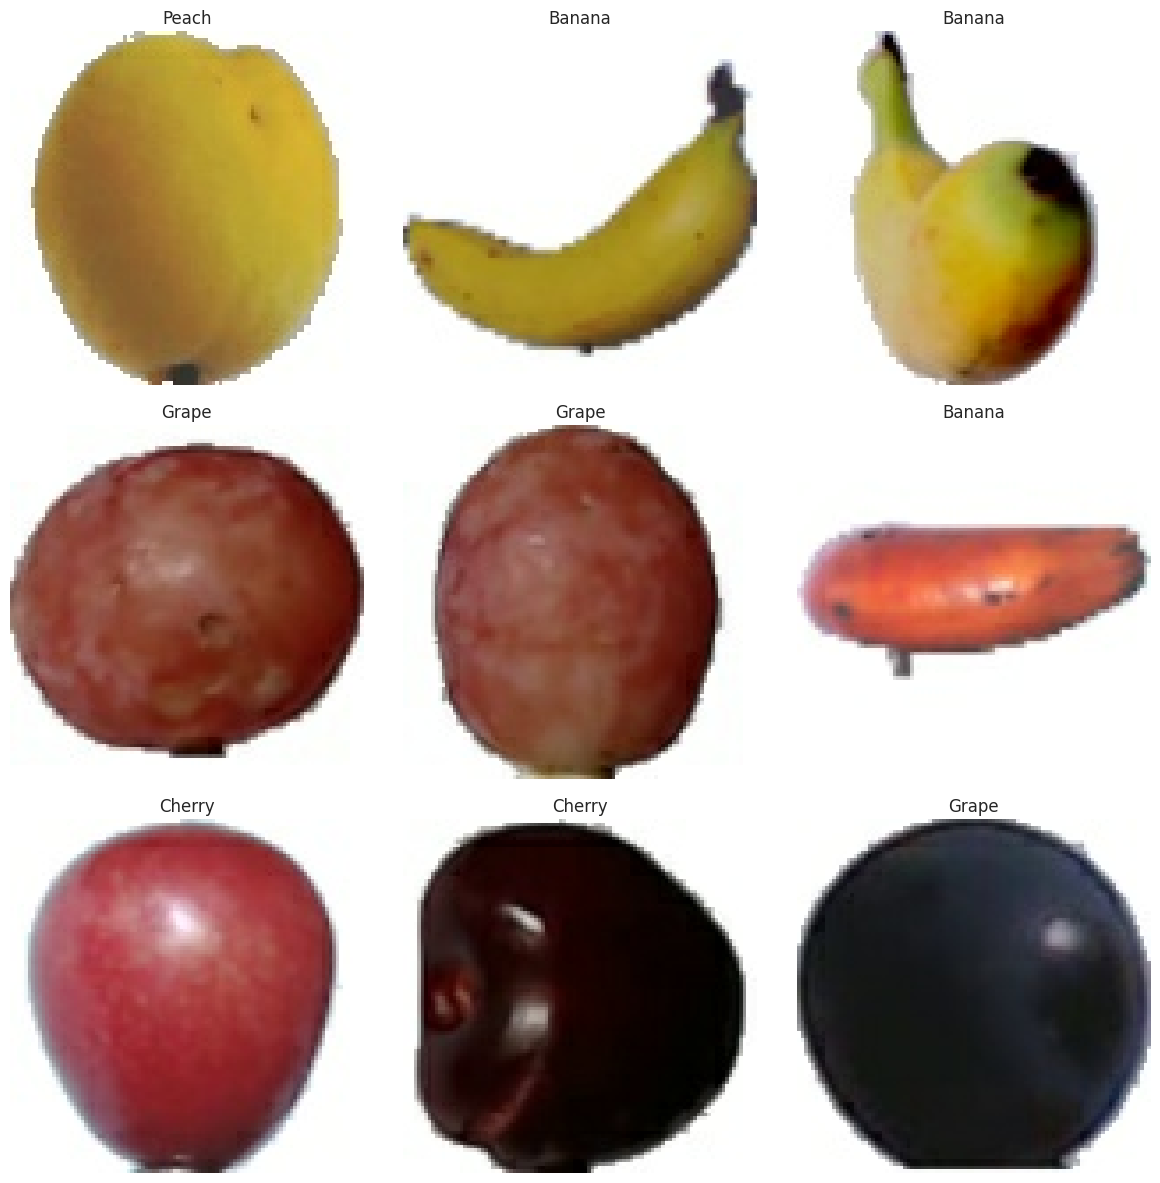

In [31]:
# Function to predict input examples and plot the results
def predict_and_plot(model, dataset, class_names):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        num_images = min(9, len(images))
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            pred_label = class_names[np.argmax(predictions[i])]
            plt.title(pred_label)
            plt.axis("off")
    plt.tight_layout()
    plt.show()

# Create test dataset
test_dir = "/content/drive/MyDrive/FruitClassification/Fruitclassification/Test"
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size=32,
    image_size=(100, 100),
    shuffle=True,
    label_mode='categorical'
)

#Extract class names
class_names = test_ds.class_names

# Evaluate the model on the test dataset
test_loss, test_accuracy = baseline_model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict and plot examples from the test set
predict_and_plot(baseline_model, test_ds, class_names)


In [32]:
def generate_model(image_height, image_width, nchannels, num_classes):
  """
  This function will generate a model with set of hyperparameters defined above.
  Input Args:
  image_height[int] = Height of an image.
  image_width[int] = Width of an image.
  nchannels[int] = Number of channels in image.
  num_classes[int] = Number of classes in dataset.
  Output Args:
  model-> A CNN model.
  """
  regularized_model = tf.keras.Sequential([
      # Rescaling and input layer, [For keras the input shape must be(image height, image width, channels)]
      layers.Rescaling(1./255, input_shape=(image_height,image_width, nchannels)),
      # First Block of Convolution and Pooling Operations.
      layers.Conv2D(32, (3,3), padding="same", activation="relu"),
      layers.BatchNormalization(),
      layers.MaxPooling2D(2,2),
      # Second Block of Convolution and Pooling Operations.
      layers.Conv2D(64, (3,3), padding="same", activation="relu"),
      layers.BatchNormalization(),
      layers.MaxPooling2D(2,2),
      # Third Block of Convolution and Pooling Operations.
      layers.Conv2D(128, (3,3), padding="same", activation="relu"),
      layers.BatchNormalization(),
      layers.MaxPooling2D(2,2),

      # Fourth Block of Convolution and Pooling Operations.
      layers.Conv2D(256, (3,3), padding="same", activation="relu"),
      layers.BatchNormalization(),
      layers.MaxPooling2D(2,2),

      # Fully connected classifier.
      layers.Flatten(),
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(128, activation="relu"),
      layers.Dropout(0.5),
      layers.Dense(64, activation='relu'),
      layers.Dense(num_classes, activation='softmax')
  ])
  return regularized_model

In [33]:
num_classes = len(class_names)
regularized_model = generate_model(img_height, img_width, 3, num_classes)


In [34]:
regularized_model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])


In [35]:
regularized_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,791,365 (10.65 MB)

 Trainable params: 2,790,405 (10.64 MB)

 Non-trainable params: 960 (3.75 KB)

In [36]:
epochs = 40
history = regularized_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callbacks]
)

Epoch 1/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 26s 162ms/step - accuracy: 0.7220 - loss: 1.1831 - val_accuracy: 0.4726 - val_loss: 1.4496
Epoch 2/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.9730 - loss: 0.0697 - val_accuracy: 0.5339 - val_loss: 6.3896
Epoch 3/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.9932 - loss: 0.0206 - val_accuracy: 0.6783 - val_loss: 3.3198
Epoch 4/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - accuracy: 0.9624 - loss: 0.1968 - val_accuracy: 0.9584 - val_loss: 0.1890
Epoch 5/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - accuracy: 0.9880 - loss: 0.0453 - val_accuracy: 1.0000 - val_loss: 3.9606e-06
Epoch 6/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - accuracy: 0.9937 - loss: 0.0343 - val_accuracy: 0.9967 - val_loss: 0.0064
Epoch 7/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - accuracy: 0.9894 - loss: 0.0581 - val_accuracy: 0.9880 - val_loss: 0.0936
Epoch 8/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.9925 - loss:

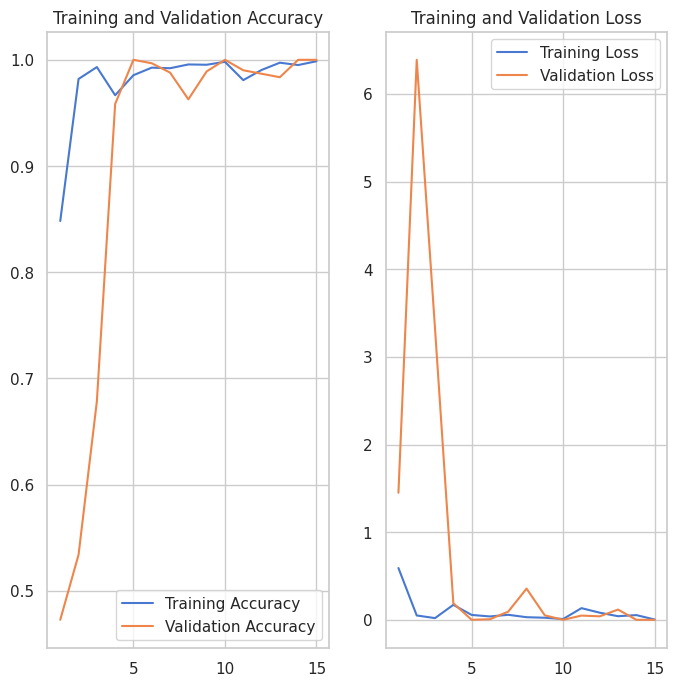

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Adjust the lengths of the arrays to match the actual number of epochs executed
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
test_loss, test_accuracy = regularized_model.evaluate(val_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.0000 - loss: 3.7631e-10
Test Loss: 3.9127773243663455e-10
Test Accuracy: 1.0


Found 1690 files belonging to 5 classes.
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 1.0000 - loss: 5.8084e-09
Test Loss: 5.3608859573728296e-09
Test Accuracy: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


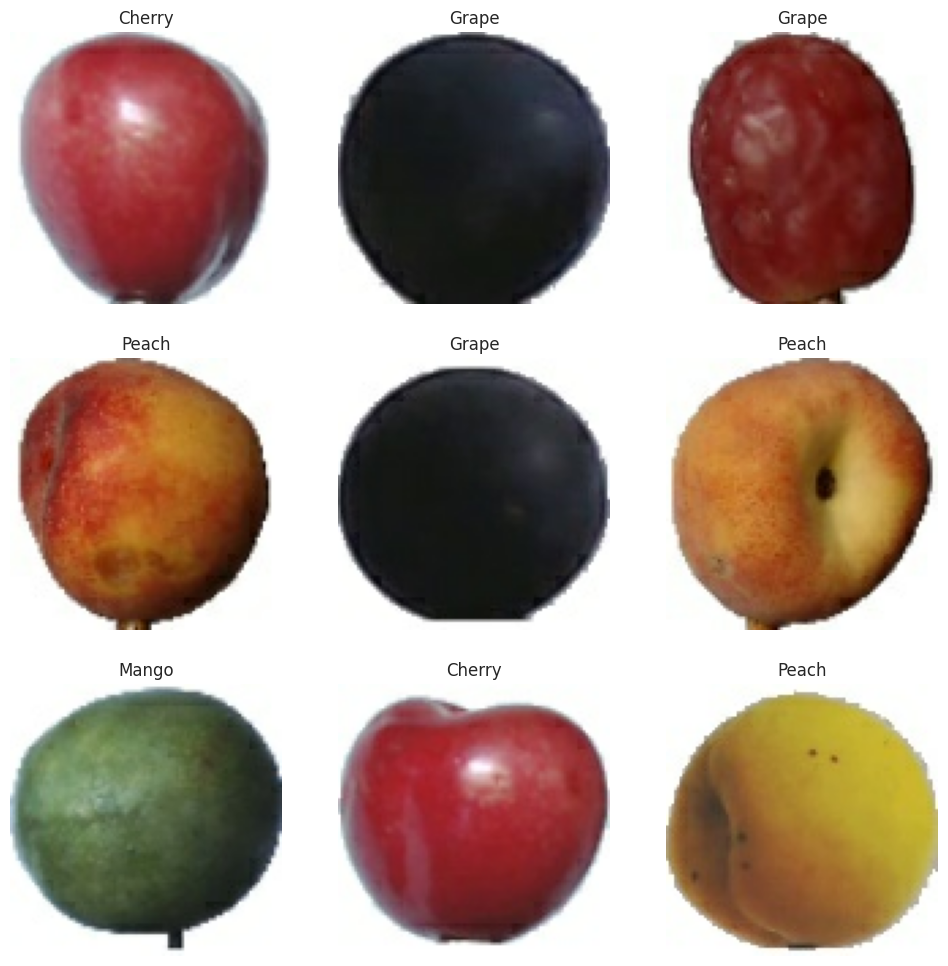

In [39]:


# Function to predict input examples and plot the results
def predict_and_plot(model, dataset, class_names):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            pred_label = class_names[np.argmax(predictions[i])]
            plt.title(pred_label)
            plt.axis("off")

# Create test dataset
test_dir = "/content/drive/MyDrive/FruitClassification/Fruitclassification/Test"
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size=32,
    image_size=(100, 100),
    shuffle=True,
    label_mode='categorical'
)

#Extract class names
class_names = test_ds.class_names

# Evaluate the model on the test dataset
test_loss, test_accuracy = regularized_model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict and plot examples from the test set
predict_and_plot(regularized_model, test_ds, class_names)


In [40]:
train_ds = train_ds = tf.keras.utils.image_dataset_from_directory(
ds_path,
batch_size=32,
image_size=(100, 100),
shuffle=True,
seed=123,
validation_split=0.2,
subset="training",
label_mode='categorical'
)

Found 4570 files belonging to 5 classes.
Using 3656 files for training.


In [41]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(100,100,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(512, activation='relu'))
resnet_model.add(layers.Dropout(0.5)),
resnet_model.add(layers.BatchNormalization()),
resnet_model.add(layers.Dense(5, activation='softmax'))

In [42]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [43]:
resnet_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,641,413 (94.00 MB)

 Trainable params: 1,052,677 (4.02 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

In [44]:
epochs=40
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 227ms/step - accuracy: 0.9173 - loss: 0.2411 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 2/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.9994 - loss: 0.0047 - val_accuracy: 1.0000 - val_loss: 4.8302e-04
Epoch 3/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 2.8365e-04
Epoch 4/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 1.4160e-04
Epoch 5/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 1.0688e-04
Epoch 6/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 1.0000 - loss: 6.7979e-04 - val_accuracy: 1.0000 - val_loss: 5.9679e-05
Epoch 7/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - accuracy: 1.0000 - loss: 6.0287e-04 - val_accuracy: 1.0000 - val_loss: 4.3528e-05
Epoch 8/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/ste

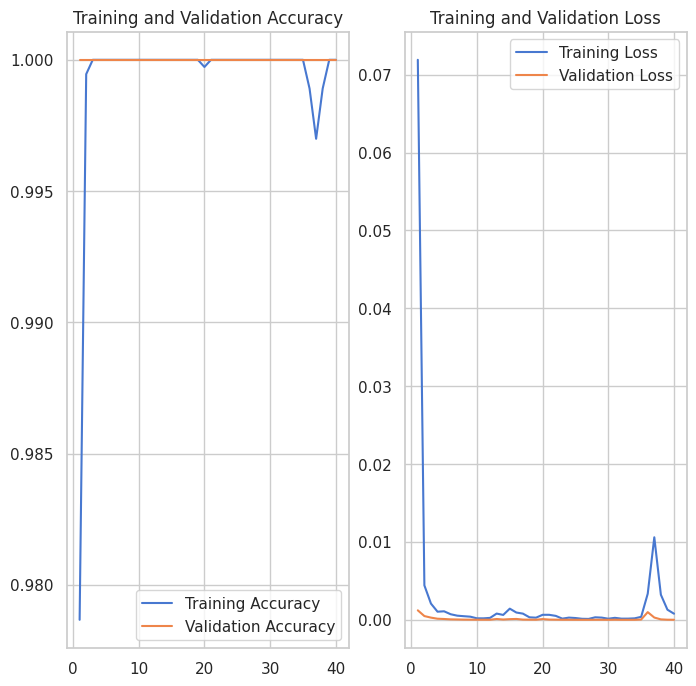

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Adjust the lengths of the arrays to match the actual number of epochs executed
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [46]:
test_loss, test_accuracy = resnet_model.evaluate(val_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 1.0000 - loss: 6.8009e-06
Test Loss: 7.265724889293779e-06
Test Accuracy: 1.0


In [47]:
baseline_model.save('baseline_model_SujalPrajapati.h5')
regularized_model.save('regularized_model_SujalPrajapati.h5')
resnet_model.save('resnet_model_SujalPrajapati.h5')